In [52]:
import numpy as np
import pandas as pd

from sklearn.datasets import fetch_openml

import matplotlib as mpl
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

In [6]:
mnist = fetch_openml('mnist_784', version=1)

In [66]:
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [67]:
# store the features as a pandas DataFrame and the target variable as a pandas Series.

X, y = mnist["data"], mnist["target"]

type(X), type(y)

(pandas.core.frame.DataFrame, pandas.core.series.Series)

In [68]:
X.shape, y.shape

((70000, 784), (70000,))

In [69]:
X.head()

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [70]:
y.head()

0    5
1    0
2    4
3    1
4    9
Name: class, dtype: category
Categories (10, object): ['0', '1', '2', '3', ..., '6', '7', '8', '9']

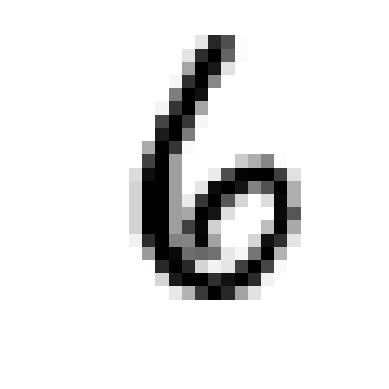

In [71]:
some_digit = X.iloc[2300,:].values
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap = mpl.cm.binary, interpolation="nearest")
plt.axis("off")
plt.show()

In [72]:
y[2300]

'6'

In [73]:
y = y.astype(np.uint8)

In [75]:
y[2300]

6

In [76]:
X.isnull().any().any()

False

In [77]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [80]:
from scipy.ndimage.interpolation import shift

# function that takes an image as input and performs the shift
def image_shifter(image, shft_x, shft_y):
    image = image.reshape((28, 28))
    shifted_image = shift(image, [shft_y, shft_x], cval=0, mode='constant')
    return shifted_image.reshape([-1])

In [84]:
# Convert X_train DataFrame to NumPy array

X_train = X_train.values

In [85]:
# new training data sets

X_train_shifted = []
y_train_shifted = []

In [86]:
for image, label in zip(X_train, y_train):

    X_train_shifted.append(image)
    y_train_shifted.append(label)

    shft_up = image_shifter(image,0,-1)
    X_train_shifted.append(shft_up)
    y_train_shifted.append(label)

    shft_down = image_shifter(image,0,1)
    X_train_shifted.append(shft_down)
    y_train_shifted.append(label)

    shft_left = image_shifter(image,-1,0)
    X_train_shifted.append(shft_left)
    y_train_shifted.append(label)

    shft_right = image_shifter(image,1,0)
    X_train_shifted.append(shft_right)
    y_train_shifted.append(label)

In [87]:
# Convert augmented data and labels to numpy arrays
shuffle = np.random.permutation(len(X_train_shifted))
X_train_augmented = np.array(X_train_shifted)[shuffle]
y_augmented = np.array(y_train_shifted)[shuffle]

# Verify the new size of the augmented dataset
print("Original training dataset size:", X_train.shape[0])
print("Augmented training dataset size:", X_train_augmented.shape[0])

Original training dataset size: 60000
Augmented training dataset size: 300000


In [88]:
import pickle

sgd_clf = pickle.load(open('sgd_clf_multiclass.pkl', 'rb')) # load saved model

In [89]:
sgd_clf.fit(X_train_augmented,y_augmented)

SGDClassifier(random_state=42)

In [90]:
sgd_clf.predict([some_digit])

array([6])

In [92]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train_augmented, y_augmented, cv=3, scoring="accuracy")

array([0.83629, 0.80949, 0.81555])

In [93]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

y_train_pred = cross_val_predict(sgd_clf, X_train_augmented, y_augmented, cv=3)
conf_mx = confusion_matrix(y_augmented, y_train_pred)
conf_mx 

array([[27067,     6,   512,   142,   158,   420,   283,   181,   750,
           96],
       [   84, 29517,   250,   324,   196,   234,   109,   356,  2460,
          180],
       [  263,   250, 24354,   456,   529,   211,   778,   727,  1996,
          226],
       [  239,   189,  1692, 22973,   136,  1542,   196,   686,  2462,
          540],
       [  111,   136,   379,    89, 24427,   191,   375,   535,  1012,
         1955],
       [  550,   115,   434,  1725,   596, 20556,   643,   323,  1833,
          330],
       [  293,   243,   430,    74,   409,   743, 26273,    18,  1085,
           22],
       [  190,    94,   345,   143,   433,   113,    42, 28050,   678,
         1237],
       [  299,   436,   507,   929,   540,  1122,   189,   432, 24092,
          709],
       [  223,   100,   173,   607,  2670,   574,    19,  4590,  1965,
        18824]], dtype=int64)

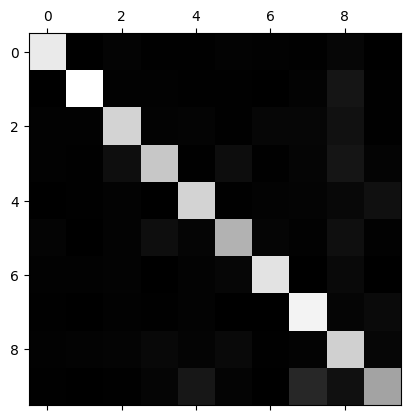

In [94]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

In [95]:
sgd_clf.fit(X_test, y_test) 
sgd_clf.predict([some_digit])

c:\Users\Aobando\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


array([6], dtype=uint8)

In [96]:
cross_val_score(sgd_clf, X_test, y_test, cv=3, scoring="accuracy")

array([0.82783443, 0.85448545, 0.8919892 ])